In [1]:
%pylab inline
from ipywidgets import interact
import scipy.stats
from skimage import img_as_float, img_as_ubyte
from matplotlib.image import imread
import glob,os
from numpy import genfromtxt
import pandas as pd
from pandas import DataFrame as df
#import numpy as np
#import matplotlib

Populating the interactive namespace from numpy and matplotlib


References and useful links:
- [PDF of book exploring P, Solubility etc.](http://www.pharmaresearchlibrary.com/wp-content/uploads/2013/03/absorption_and_drug_development_-_solubility_permeability_and_charge_state.pdf) - Page 160
- [Yohan Lee paper exploring SLB, UV detection platform](https://pubs.acs.org/doi/pdf/10.1021/acs.analchem.7b03004)
- [Notes on error propagation](http://lectureonline.cl.msu.edu/~mmp/labs/error/e2.htm)
- [Markdown - mathematical formula](http://csrgxtu.github.io/2015/03/20/Writing-Mathematic-Fomulars-in-Markdown/)

### Permeability equation

Mass balance:

$$ {C_D(0) V_D(t)} + {C_A(0) V_A(t)} = {C_A(t) V_A(t)}+{C_D(t) V_D(t)}$$

If we assume that VD and VA are equal:

$$ C_D(0) + C_A(0) = C_A(t)+C_D(t)$$

This defines the equilbrium concentration as:

$$ C_{EQ} = \frac {C_D(0) + C_A(0)}{2}$$

Or:

$$ 2 C_{EQ} = C_D(t) + C_A(t)$$

Fitting this back into Ficks first law:

$$ \frac {\partial{C_A (t)}}{\partial{t}} = \frac {A}{V_A} 2 P (C_{EQ} - C_A(t)) $$
 
In terms of P:

$$ P = \frac {V_A} {2 A (C_{EQ} - C_A(t))} \frac {\partial{C_A (t)}}{\partial{t}} $$

In [2]:
# Represents Ficks first law as interpreted in terms of RheoDib permeability
def PermeabilityRheoDIB (VA,A,CEQ,CAt,dCdt):
    "Returns a value for P"
    return (VA / (2*A*(CEQ-CAt))) * (dCdt)

#Determines the area of a circle 
def circlearea (r):
    "Return the area of a circle based on the radius"
    return np.pi * r **2

 First we need to approximate the bilayer area. In the case of a DIB we can use A = πR<sup>2</sup> and make the assumption that the bilayer is a flat circle. Therefore we can just use the radius of the interface as measured by microscopy. The bilayer area was determined via microscopy previously via an n=4 dataset.

In [3]:
DIB17radius = 0.81 / 2    #three different radii are determined based on image analysis.
DIB3radius = 0.82/2
DIBX_2radius = 0.74/2


DIB17area = circlearea(DIB17radius/10)  # convert to cm from mm and conduct area calculation using pi*r^2
DIB3area = circlearea(DIB3radius/10) 
DIBX_2area = circlearea(DIBX_2radius/10)


DIBavr = (DIB17radius,DIB3radius, DIBX_2radius) # store the radii into a single variable
DIBavA = (DIB17area, DIB3area, DIBX_2area)

DIBavmean = np.mean(DIBavA) # two different ways of detemring area
average_DIBarea = ((DIB17area + DIB3area + DIBX_2area) / 3)  # this variable will be used downstream

average_DIBareasd = std(DIBavA, ddof=1)
no_elements = len(DIBavA)
average_DIBarease = average_DIBareasd/(no_elements**0.5)

In [4]:
print('As determined via microscopy the average DIB area within the RheoDIB is:' , average_DIBarea )
print('As determined via microscopy the standard error in DIB area within the RheoDIB is:' , average_DIBarease)

As determined via microscopy the average DIB area within the RheoDIB is: 0.0049116183144998415
As determined via microscopy the standard error in DIB area within the RheoDIB is: 0.00030761695434825643


# Calibration

In considering the calibration method, it is worth taking into account the effect of [Heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). This effect describes how sub populations of a data series may exert local variability outside of the general trend. In the case of the RheoDIB, quantifying higher concentrations becomes unclear.

The calibration data will have to be added into a single directory and then this directory will be analysed.

In [5]:
### File: OpenAndFitData1.py

## Import plots, and numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob, os
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import pandas as pd

## Extract data from file
def extractSpectraFromFile(file_name):
    # open file, get data, close file
    with open(file_name) as myFile:
        text = myFile.read()
        delims_str = '>>>>>Begin Spectral Data<<<<<'
        sample_info, spectra = text.split(delims_str) # split data into sample info and raw spectra
        myFile.close()
    return spectra, sample_info

## Convert spectra from str to float
def convertSpectraToFloat(spectr_str):
    # split string into list
    spectra = spectr_str.split()
    
    wavelength = []
    intensity = []

    for i, val in enumerate(spectra):
        if i % 2 == 0:
            wavelength.append(float(val))
        else:
            intensity.append(float(val))
    
    return wavelength, intensity


## Normalzie and reduce data
def normalizeAndReduce(wavelength, intensity, lower_bin, upper_bin):
    count1 = 0
    count2 = 0
    sumwave1 = 0
    sumwave2 = 0
    
    # enumerate data - lower bin first 
    for i, val in enumerate(wavelength):
        if val >= lower_bin[0] and val <= lower_bin[1]:
            sumwave1 +=  intensity[i]
            count1 += 1
    # enumerate data - upper bin second 
    for i, val in enumerate(wavelength):
        if val >= upper_bin[0] and val <= upper_bin[1]:
            sumwave2 = sumwave2 + intensity[i]
            count2 += 1

    return ((sumwave1 / count1) / (sumwave2 / count2)) * 100

def fitfunc(t, k, MTV, CaO):
        #'Function that returns Ca computed from an ODE for a rate k, moles MTV, and IC CaO'
        #Ca0 = Ca_data[0]
        # the lambda function syntax is sometimes more compact and readable
        Casol = odeint(lambda Ca, t: -k * (2 * Ca - MTV), CaO, t)
        #Casol = odeint(myode, CaO, t) ## or call myode as a nested function above
        return Casol[:,0]

In [6]:
# rootdir = r'C:/Users/fts18/OneDrive - Imperial College London/MRes/Permeability Assays/Test-SPECTRA'
# base_files = os.listdir(rootdir)


# all_data = []

# for bf in base_files:
#     if not bf.startswith('.'):
#         level1_files = os.listdir(rootdir+'/'+bf)  #allows file to be read
#         for l1f in level1_files:
#             spectra, sample_info = extractSpectraFromFile(rootdir+'/'+bf+'/'+l1f)
#             wavelength, intensity = convertSpectraToFloat(spectra)
#             #plt.plot(wavelength,intensity, linewidth = 2)
#             plt.xlim(240,300)
#             all_data.append({ 
#                           'Wavelength': wavelength,
#                           'Intensity': intensity})  
#             plt.plot(wavelength,intensity, linewidth=1)
#             #plt.xlim(540,650)  

#         all_spectraldata = pd.DataFrame(all_data)
        
    
# #if wavelength >540 and <650
# all_spectraldata

### Perform calibration

To make this work - we may need to specify a specific way of saving the files within the directory.

250_1


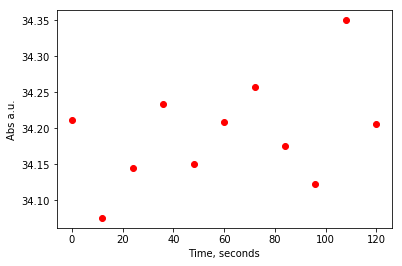

250_2


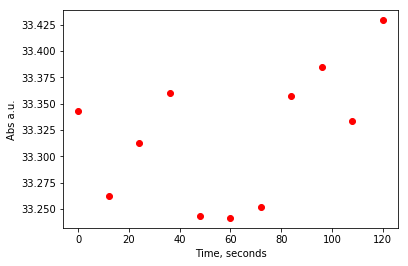

250_3


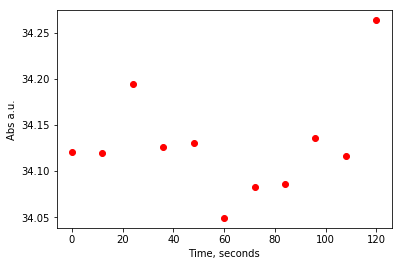

375_1


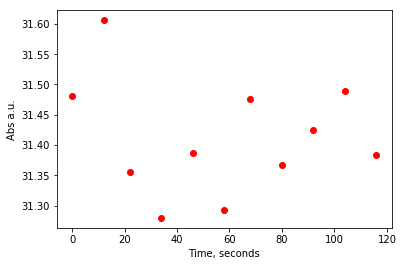

375_2


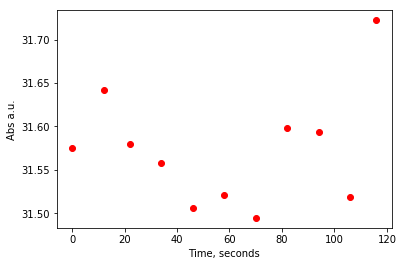

375_3


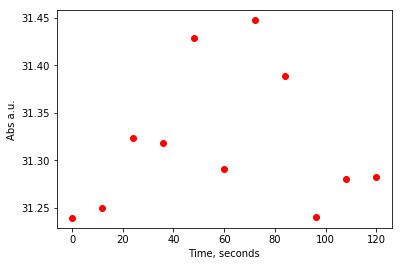

500_1


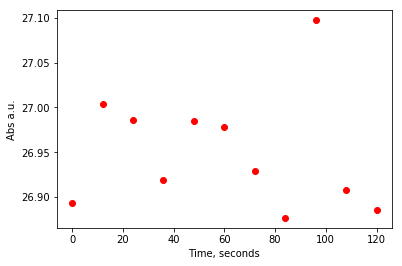

500_2


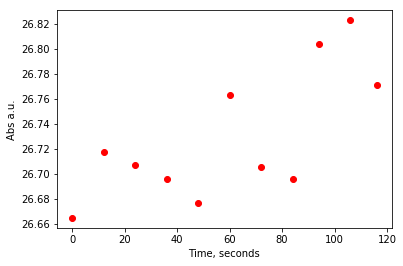

500_3


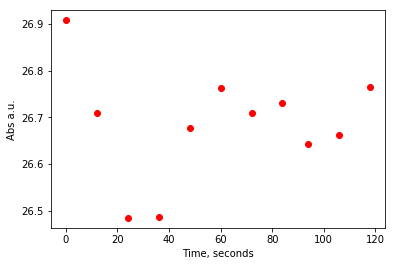

,Absorbance,Average of run,Average of run error,File name,Timestamps
0,"[34.21202819463932, 34.075776171828984, 34.145...",34.194371,0.006695,250_1,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]"
1,"[33.34295405627256, 33.262611589723626, 33.313...",33.320107,0.005740,250_2,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]"
2,"[34.12071639444148, 34.11951648375613, 34.1941...",34.129625,0.005219,250_3,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]"
3,"[31.481714630242024, 31.60594969029427, 31.356...",31.413371,0.008663,375_1,"[0, 12, 22, 34, 46, 58, 68, 80, 92, 104, 116]"
4,"[31.575753600157636, 31.641598204234995, 31.57...",31.573581,0.006077,375_2,"[0, 12, 22, 34, 46, 58, 70, 82, 94, 106, 116]"
5,"[31.239601791890593, 31.250283237059456, 31.32...",31.317457,0.006685,375_3,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]"
6,"[26.893300472469644, 27.003323757285603, 26.98...",26.950989,0.006019,500_1,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]"
7,"[26.664730708418134, 26.717193762714214, 26.70...",26.729422,0.004772,500_2,"[0, 12, 24, 36, 48, 60, 72, 84, 94, 106, 116]"
8,"[26.907708737438302, 26.710168191446932, 26.48...",26.684945,0.011036,500_3,"[0, 12, 24, 36, 48, 60, 72, 84, 94, 106, 118]"


In [15]:
rootdir = r'C:/Users/fts18/OneDrive - Imperial College London/MRes/Permeability Assays/Paracetamol_DOPC/4_4_19/Calibrations'
base_files = os.listdir(rootdir)

Spectraldata = []  #extract the result from each loop iteration / directory
Timedata = []

all_data_proxy = []

for bf in base_files:

    if not bf.startswith('.'): #and os.path.isfile(os.path.join(rootdir, bf)):
        
        level1_files = os.listdir(rootdir+'/'+bf)  #allows file to be read

        fitdata1 = []
        timestamp = []
        print(bf)  # print title

        for l1f in level1_files:



        # get spectra and sample info and break specra into wavelength and intensity as float
            spectra, sample_info = extractSpectraFromFile(rootdir+'/'+bf+'/'+l1f)
            wavelength, intensity = convertSpectraToFloat(spectra)

            # sample name, get time stamp
            #sample = "HR4C15671_09-25-48-792.txt" ## use this to override sample name
            sample = l1f
            #print ('sample label:', sample)
            hrs, mins, secs = map(int, sample.split("_")[1].split("-")[:3])
            timestamp.append((hrs * 60 * 60) + (mins * 60) + (secs))

            normdata1 = normalizeAndReduce(wavelength, intensity, lower_bin=(240, 270), upper_bin=(500, 550))

            #print(normdata1)
            fitdata1.append(normdata1)

        ## Perform fit to 1st order ODE
        # given data we want to fit and shift time to zero
        timestamp[:]=[x-timestamp[0] for x in timestamp]
        tspan = timestamp
        Ca_data = fitdata1

        #fit and covariance of fit with initial guesses p0 
        #k_fit, kcov = curve_fit(fitfunc, tspan, Ca_data, p0=[0.00005,0.1,62]) #p0=[k, MTV, CaO]
        #perr = np.sqrt(np.diag(kcov)) # 1 standard deviation
        #print ('k value is ', k_fit)
        #print ('first point in data is ', Ca_data[0])
        #print ('covariance value is ', kcov)
        #print ('the variance on k and CaO (diagonals) are ', perr)
        #print(tspan, Ca_data)

        #tfit = np.linspace(0,tspan[-1],num = 1000)
        #fit = fitfunc(tfit, k_fit[0],k_fit[1],k_fit[2])
        #k_fit[0] = k,  k_fit[1] = MTV,  k_fit[2] = CaO
        
        plt.plot(tspan, Ca_data, 'ro', label='data')
        #plt.plot(tfit, fit, 'b-', label='fit')
        #plt.legend(loc='best')
        plt.ylabel('Abs a.u.')
        plt.xlabel('Time, seconds')
        plt.show()
        Spectraldata.append(Ca_data) # update list for both time and data
        Timedata.append(tspan)

        all_data_proxy.append({'File name': bf, 
                          'Timestamps': tspan,
                          'Absorbance': Ca_data, 
                          'Average of run': np.mean(Ca_data),
                          'Average of run error': (np.std(Ca_data, ddof=1))/len(Ca_data)})  

        all_calibdata = pd.DataFrame(all_data_proxy) # this is where the dataframe is completed.
all_calibdata

In [16]:
# maxabs_20 = np.argmax(all_calibdata['Absorbance'][0])
# all_calibdata['Absorbance'][0][maxabs_20]
# minabs_20 = np.argmin(all_calibdata['Absorbance'][0])
# all_calibdata['Absorbance'][0][minabs_20]

# diffabs_20 = (all_calibdata['Absorbance'][0][maxabs_20]) - (all_calibdata['Absorbance'][0][minabs_20])
# print('Over two hours, the light source drifted by -'+ str(diffabs_20))

# maxabs_21 = np.argmax(all_calibdata['Absorbance'][1])
# all_calibdata['Absorbance'][1][maxabs_21]
# minabs_21 = np.argmin(all_calibdata['Absorbance'][1])
# all_calibdata['Absorbance'][1][minabs_21]

# diffabs_21 = (all_calibdata['Absorbance'][1][maxabs_21]) - (all_calibdata['Absorbance'][1][minabs_21])
# print('Over two hours, the light source drifted by -'+ str(diffabs_21))

# maxabs_22 = np.argmax(all_calibdata['Absorbance'][2])
# all_calibdata['Absorbance'][2][maxabs_22]
# minabs_22 = np.argmin(all_calibdata['Absorbance'][2])
# all_calibdata['Absobance'][2][minabs_22]


# diffabs_22 = (all_calibdata['Absorbance'][2][maxabs_22]) - (all_calibdata['Absorbance'][2][minabs_22])
# print('Over two hours, the light source drifted by -'+ str(diffabs_22))

0.005080187204490112 -0.9843444986660134 -0.028371664083679988 41.34091486367118


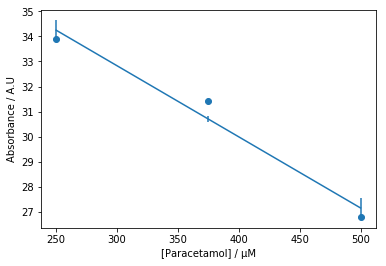

In [20]:
# vals50_1 = all_calibdata['Average of run'][18]#index in the calibration data
# vals50_2 = all_calibdata['Average of run'][19]
# vals50_3 = all_calibdata['Average of run'][20]

# vals100_1 = all_calibdata['Average of run'][3]
# vals100_2 = all_calibdata['Average of run'][4]
# vals100_3 = all_calibdata['Average of run'][5]

vals250_1 = all_calibdata['Average of run'][all_calibdata['File name']=='250_1'].values
vals250_2 = all_calibdata['Average of run'][all_calibdata['File name']=='250_2'].values
vals250_3 = all_calibdata['Average of run'][all_calibdata['File name']=='250_3'].values

vals375_1 = all_calibdata['Average of run'][all_calibdata['File name']=='375_1'].values
vals375_2 = all_calibdata['Average of run'][all_calibdata['File name']=='375_2'].values
vals375_3 = all_calibdata['Average of run'][all_calibdata['File name']=='375_3'].values

vals500_1 = all_calibdata['Average of run'][all_calibdata['File name']=='500_1'].values
vals500_2 = all_calibdata['Average of run'][all_calibdata['File name']=='500_2'].values
vals500_3 = all_calibdata['Average of run'][all_calibdata['File name']=='500_3'].values

# vals675_1 = all_calibdata['Average of run'][all_calibdata['File name']=='675_1'].values
# vals675_2 = all_calibdata['Average of run'][all_calibdata['File name']=='675_2'].values
# vals675_3 = all_calibdata['Average of run'][all_calibdata['File name']=='675_3'].values

# vals750_1 = all_calibdata['Average of run'][all_calibdata['File name']=='750_1'].values
# vals750_2 = all_calibdata['Average of run'][all_calibdata['File name']=='750_2'].values
# vals750_3 = all_calibdata['Average of run'][all_calibdata['File name']=='750_3'].values

# vals875_1 = all_calibdata['Average of run'][all_calibdata['File name']=='875_1'].values
# vals875_2 = all_calibdata['Average of run'][all_calibdata['File name']=='875_2'].values
# vals875_3 = all_calibdata['Average of run'][all_calibdata['File name']=='875_3'].values

# vals1000_1 = all_calibdata['Average of run'][all_calibdata['File name']=='1000_1'].values
# vals1000_2 = all_calibdata['Average of run'][all_calibdata['File name']=='1000_2'].values
# vals1000_3 = all_calibdata['Average of run'][all_calibdata['File name']=='1000_3'].values

# vals1500_1 = all_calibdata['Average of run'][6]
# vals1500_2 = all_calibdata['Average of run'][7]
# vals1500_3 = all_calibdata['Average of run'][8]

# vals2000_1 = all_calibdata['Average of run'][9]
# vals2000_2 = all_calibdata['Average of run'][10]
# vals2000_3 = all_calibdata['Average of run'][11]

#vals500 = all_calibdata.loc[['4', '5', '10'],['Average of run']]
#vals50_mean = np.mean([vals50_1, vals50_2, vals50_3])
#vals100_mean = np.mean([vals100_1, vals100_2, vals100_3])
# vals50_mean = np.mean([vals50_1, vals50_2, vals50_3])
# vals100_mean = np.mean([vals100_1, vals100_2, vals100_3])
vals250_mean = np.mean([vals250_1, vals250_2, vals250_3])
vals375_mean = np.mean([vals375_1, vals375_2, vals375_3])
vals500_mean = np.mean([vals500_1, vals500_2, vals500_3])
# vals750_mean = np.mean([vals750_1, vals750_2, vals750_3])
# vals1000_mean = np.mean([vals1000_1, vals1000_2])
# vals1500_mean = np.mean([vals1500_1, vals1500_2, vals1500_3])
# vals2000_mean = np.mean([vals2000_1, vals2000_2, vals2000_3])

vals250_std = np.std([vals250_1, vals250_2, vals250_3])
vals375_std = np.std([vals375_1, vals375_2, vals375_3])
vals500_std = np.std([vals250_1, vals250_2, vals250_3])
# vals750_std = np.std([vals750_1, vals750_2, vals750_3])
# vals1000_std = np.std([vals1000_1, vals1000_2, vals1000_3])

all_std = [vals250_std, vals375_std, vals500_std]

concs = np.array([250, 375, 500])
raws = np.array([vals250_mean, vals375_mean, vals500_mean])



calibslope, calibintercept, calibr_value, calibp_value, calib_err = scipy.stats.linregress(concs, raws)

plt.scatter(concs, raws)
plt.ylabel('Absorbance / A.U')
plt.xlabel('[Paracetamol] / \u03BCM')
#plt.plot(concs, calibslope*concs + calibintercept, linestyle='--')
plt.errorbar(concs, calibslope*concs + calibintercept, yerr=all_std)
print(calib_err, calibr_value, calibslope, calibintercept)


### Create dataframe with all the permeability run data

500D_250A_2


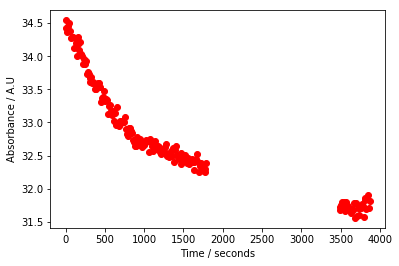

500D_250A_3


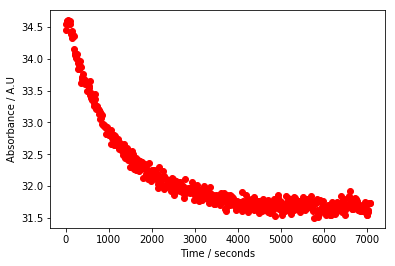

,Absorbance,Average of run,Average of run error,File name,Timestamps
0,"[34.54316543903971, 34.42394499498558, 34.3717...",32.786162,0.004053,500D_250A_2,"[0, 10, 22, 34, 46, 56, 68, 80, 92, 104, 116, ..."
1,"[34.55216322464116, 34.454695422531806, 34.591...",32.144721,0.001175,500D_250A_3,"[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 118, ..."


In [93]:
rootdir = r'C:/Users/fts18/OneDrive - Imperial College London/MRes/Permeability Assays/Paracetamol_DOPC/4_4_19/Permnospin'  #rootdirectory goes here - use forward slashes
base_files = os.listdir(rootdir)

Spectraldata = []  #extract the result from each loop iteration / directory
Timedata = []

all_data_proxy = []

for bf in base_files:

    if not bf.startswith('.'): #and os.path.isfile(os.path.join(rootdir, bf)):
        
        level1_files = os.listdir(rootdir+'/'+bf)  #allows file to be read

        fitdata1 = []
        timestamp = []

        print(bf)  # print title

        for l1f in level1_files:



        # get spectra and sample info and break specra into wavelength and intensity as float
            spectra, sample_info = extractSpectraFromFile(rootdir+'/'+bf+'/'+l1f)
            wavelength, intensity = convertSpectraToFloat(spectra)

            # sample name, get time stamp
            #sample = "HR4C15671_09-25-48-792.txt" ## use this to override sample name
            sample = l1f
            #print ('sample label:', sample)
            hrs, mins, secs = map(int, sample.split("_")[1].split("-")[:3])
            #print(hrs, mins, secs)
            timestamp.append((hrs * 60 * 60) + (mins * 60) + (secs))

            normdata1 = normalizeAndReduce(wavelength, intensity, lower_bin=(240, 270), upper_bin=(500, 550))

            #print(normdata1)
            fitdata1.append(normdata1)

        ## Perform fit to 1st order ODE
        # given data we want to fit and shift time to zero
        timestamp[:]=[x-timestamp[0] for x in timestamp]
        tspan = timestamp
        Ca_data = fitdata1

        #fit and covariance of fit with initial guesses p0 
        #k_fit, kcov = curve_fit(fitfunc, tspan, Ca_data, p0=[0.00005,0.1,62]) #p0=[k, MTV, CaO]
        #perr = np.sqrt(np.diag(kcov)) # 1 standard deviation
        #print ('k value is ', k_fit)
        #print ('first point in data is ', Ca_data[0])
        #print ('covariance value is ', kcov)
        #print ('the variance on k and CaO (diagonals) are ', perr)
        #print(tspan, Ca_data)

        #tfit = np.linspace(0,tspan[-1],num = 1000)
        #fit = fitfunc(tfit, k_fit[0],k_fit[1],k_fit[2])
        #k_fit[0] = k,  k_fit[1] = MTV,  k_fit[2] = CaO

        plt.plot(tspan, Ca_data, 'ro', label='data')
        #plt.plot(tfit, fit, 'b-', label='fit')
        #plt.legend(loc='best')
        plt.ylabel('Absorbance / A.U')
        plt.xlabel('Time / seconds')
        plt.show()
        Spectraldata.append(Ca_data) # update list for both time and data
        Timedata.append(tspan)

        all_data_proxy.append({'File name': bf, 
                          'Timestamps': tspan,
                               
                          'Absorbance': Ca_data, 
                          'Average of run': np.mean(Ca_data),
                          'Average of run error': (np.std(Ca_data, ddof=1))/len(Ca_data)})  

        all_data1 = pd.DataFrame(all_data_proxy) # this is where the dataframe is completed.
all_data1

,Concentration,File name,Normalised concentration,Timestamps
0,"[203.2481849168375, 204.71521340984734, 206.62...",1,"[0.7390843087885, 0.7444189578539904, 0.751348...","[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,..."
1,"[266.0549156170926, 260.87952034711583, 268.05...",500D_250A_1,"[0.9674724204257913, 0.9486528012622394, 0.974...","[0, 12, 22, 34, 46, 56, 68, 80, 92, 102, 114, ..."
2,"[239.59642989505454, 243.79852546838777, 245.6...",500D_250A_2,"[0.8712597450729256, 0.8865400926123191, 0.893...","[0, 10, 22, 34, 46, 56, 68, 80, 92, 104, 116, ..."
3,"[239.59642989505454, 243.79852546838777, 245.6...",500D_250A_2,"[0.8712597450729256, 0.8865400926123191, 0.893...","[0, 10, 22, 34, 46, 56, 68, 80, 92, 104, 116, ..."


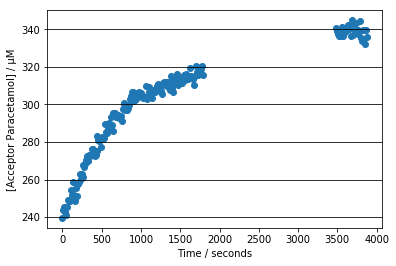

In [94]:
eq = (500 + 50)/2

solved_data1 = []

for i in range (0,1):   # the second number is how many folders there are in the directory
    raw_intensity = np.array(all_data1['Absorbance'][i])
    time = np.array(all_data1['Timestamps'][i])
    name = all_data1['File name'][i]
    conc_solved = (raw_intensity - calibintercept) / calibslope
    conc_normalised = (conc_solved) / eq
    solved_data.append({'File name': name, 
                      'Timestamps': time,
                      'Concentration': conc_solved, 
                      'Normalised concentration': conc_normalised}) 
    plt.scatter(time, conc_solved)
    plt.ylabel('[Acceptor Paracetamol] / \u03BCM')
    plt.xlabel('Time / seconds')
    plt.grid(color='black', which='major', axis='y', linestyle='solid')
    
all_solveddata = pd.DataFrame(solved_data) # this is where the dataframe is completed.
all_solveddata  

In [95]:
# x = np.array([43,54,102])
# y = np.array([500, 327, 50])

# cslope, cintercept, c_rvalue, c_pvalue, c_err = scipy.stats.linregress(x,y)
# plt.plot(x, cslope*x + cintercept)

# plt.scatter(x,y)
# plt.ylabel('[Caffeine] / \u03BCM')
# plt.xlabel('Raw absorbance / A.U')
# plt.show()
# print(c_rvalue)

In [96]:
def filterdatframe (dataframe, count, upper, lower):
    conc = np.array(dataframe['Concentration'][count])
    time = np.array(dataframe['Timestamps'][count])
    x = np.array(list(zip(conc, time)))
    conc2 = x[:,0]
    fp = x[conc2<upper]   #enter y upper limit here
    fpy = fp[:,0]
    filtered_perm = fp[fpy>lower]   #enter y lower limit here
    filtered_pconc = filtered_perm[:,0]
    filtered_ptime = filtered_perm[:,1]
    linearP = polyfit(filtered_ptime, filtered_pconc, 1, cov=True) # 1 indicates linear fit
    Pparams=linearP[0]
    pm=Pparams[0]
    pc=Pparams[1]
    return linearP, pm, pc, filtered_pconc, filtered_ptime  #returns the m and c

This function spits out an array which contains the following items (indexed):
- 0 = linearP - The covariance matrix from the linear fit
- 1 = pm - The gradient of the linear fit
- 2 = pc - The intercept of the linear fit
- 3 = filtered_pconc - The concentration filtered based on an upper and lower limit (i.e. from 0.5 - 1mM).
- 4 = filtered_ptime - The associated timestamps

Before completing the automation of determination of P, we can bolt on the consideration of error propagation. The source of error is determined by: 
- Error in calibration method - this is the same standard error as on the linear fit curve.
- Pippetting error (confidence in volume determination) - source from literature
- Error on linear region from which to extract the differential component from (above code)
- Error on bilayer area - Determined via n=X repeats of microscope studies
- Biological repeat error at P determination level 

In the RheoDIB equation the, Propagation_of_P_error function defines the error on P as derived:

Let: 

$$ m = \frac {\partial{C_A (t)}}{\partial{t}}$$

Recalling the equation:

$$ P = \frac {m V_A} {2 A (C_{EQ} - C_A(t))} $$

Taking the partial derivative of each component yields:

$$ \frac{{\partial{P}}}{{\partial{V_A}}} = \frac {m}{2 A (C_{EQ} - C_A(t))} $$

$$ \frac{{\partial{P}}}{{\partial{A}}} = \frac {m V_A}{2 A^2 (C_{EQ} - C_A(t))} $$

$$ \frac{{\partial{P}}}{{\partial{C_A}}} = \frac {m V_A}{2 A (C_{EQ} - C_A(t))^2} $$

$$ \frac{{\partial{P}}}{{\partial{m}}} = \frac {V_A}{2 A (C_{EQ} - C_A(t))} $$


Recalling the definition of error in a general function: 

$$ {\partial{R}} = \sqrt{(\frac{{\partial{X}}}{X}\partial{X})^2 + (\frac{{\partial{Y}}}{Y}\partial{Y})^2 + ...} $$

Inputing the above partial derivatives:

$$ {\partial{P}} = P \sqrt{(\frac{{\partial{V_A}}}{V_A})^2 + (\frac{{\partial{A}}}{A})^2 + {(\frac{{{\partial{m}}}}{{m}})^2 + (\frac{{\partial{CA(t)}}}{C_EQ - CA(t)})^2})}$$

In [97]:
def PermeabilityRheoDIB (VA,A,CEQ,CAt,dCdt):
    "Returns a value for P"
    return (VA / (2*A*(CEQ-CAt))) * (dCdt)

def Propagation_of_P_error (P,dVA,VA,dA,A,dcdtse,diffterm,dC,CEQ,CAt):
    "Returns a value for the propagation of error of P"
    return P*(sqrt(((dVA/VA)**2) + ((dA/A)**2) + ((dcdtse/diffterm)**2)+((dC/(CEQ-CAt))**2)))

### Perform permeability calculations

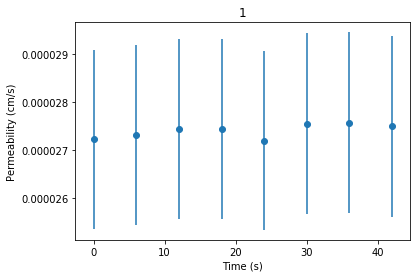

The values for permeability are: [array([2.72193498e-05, 2.73143605e-05, 2.74387723e-05, 2.74368747e-05,
       2.71940069e-05, 2.75456881e-05, 2.75674808e-05, 2.74894494e-05])]
The error for each permeability is: [array([1.86947296e-06, 1.87599846e-06, 1.88454328e-06, 1.88441295e-06,
       1.86773236e-06, 1.89188645e-06, 1.89338321e-06, 1.88802387e-06])]
The R2 value for the linear fit between the upper and lower concentration bounds is: 0.9817072481936676
The SE value for the linear fit between the upper and lower concentration bounds is: 0.0018605613325132929


,File name,Permeability,Permeability propagated error,Standard error of P,Standard error of propagated error
0,1,0.000027,0.000002,1.426967e-07,9.800658e-09


In [98]:
volume = 0.0007                    # input the volume of the acceptor compartment
volume_se = 0.000018               # based on raNdom error - Eppendorf Research® plus – Technical Specifications
average_DIBarea                    # calculated above, variable carries through
average_DIBarease                  # calculated above, variable carries through
donor_0conc = 5                    # input the intiial concentration of the donor compartment
Eq = 625                        # input the equilibrium concentration
conc_error = calib_err          # this is determined via the error on the linear fit in the calibration curve - for now the value comes from excel

dataframe = []                     # this is where the dataframe is built

for i in range (0, 1):            # no. of folders we are looking in
    values = filterdatframe(all_solveddata,i,500,0)  # this will vary the timestamps in each file as the point at which each files reaches 0.6mM
    conc = values[3]
    filt_time = values[4]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(filt_time, conc) # perform scipy statistics on fit
    permvalues = []
    permerrorvalues = []
    timevalues = []
    for x in conc, filt_time:
        concA = conc[range(0,8)]    # adjust this value for number of points within the conc range
        concD = donor_0conc - concA
        timefor = filt_time[range(0,8)]
        Pvalue = PermeabilityRheoDIB(volume,average_DIBarea,Eq,concA,slope)
        Perror = Propagation_of_P_error(Pvalue,volume_se,volume,average_DIBarease,
                                        average_DIBarea,std_err,slope,conc_error,Eq,concA)
    permvalues.append(Pvalue)
    permerrorvalues.append(Perror)
    timevalues.append(timefor)
    dataframe.append({'File name': all_solveddata['File name'][i], 
                      'Permeability': np.mean(permvalues),
                      'Standard error of P': (np.std(permvalues, ddof=1))/len(timevalues),
                      'Permeability propagated error': np.mean(permerrorvalues),
                      'Standard error of propagated error': (np.std(permerrorvalues,ddof=1))/len(timevalues)})   # this extracts all the data into the dataframe
    
    #Plotting for each iteration
    
    plt.errorbar(timevalues, permvalues, yerr=permerrorvalues, linestyle = 'none')
    plt.scatter(timevalues, permvalues, )
    #plt.yscale('log')
    #plt.ylim(0.0001,0.002)
    plt.ylabel('Permeability (cm/s)')
    plt.xlabel('Time (s)')
    plt.title(all_solveddata['File name'][i])
    plt.show()
    print ('The values for permeability are:', (permvalues))
    print('The error for each permeability is:', permerrorvalues)
    print ('The R2 value for the linear fit between the upper and lower concentration bounds is:', r_value)
    print ('The SE value for the linear fit between the upper and lower concentration bounds is:', std_err)
    
all_data = pd.DataFrame(dataframe) # this is where the dataframe is completed.
all_data

Per run, the error on m will vary. For each molecule / run of the molecule the variance on CA(t) will change, as this element accounts for the calibration. 

Across these timestamps, the average permeability was then taken and the average propagated standard error, with the se on both the average permeability and the propagted permeability error were totalled. Then for each run (n=3) this was averaged (with the same process for the totalled error). The below values condense the entire timstamp plot into single variables, which accounts for the variance in P with time. 

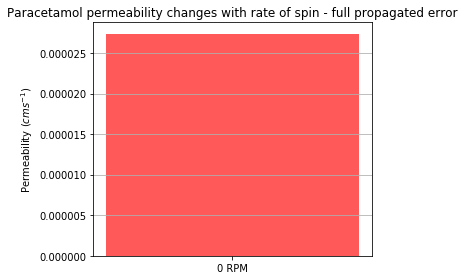

The P value at 0 rpm is: 0.27400747812226256 +/- nan x10^-4cms-1 


In [99]:
# slicing out specific integers from dataframe
p = (all_data['Permeability'])
err = (all_data['Permeability propagated error'])
err_on_P = (all_data['Standard error of P'])
err_on_properr = (all_data['Standard error of propagated error'])

#summing the error columns
errincluded = all_data.assign(my_sum=all_data[['Permeability propagated error', 'Standard error of P', 'Standard error of propagated error']].sum(1))
total_err = (errincluded['my_sum'])    
#averaging the runs (n=3) and calculating total error
mean_p = np.mean(p[0:3]) 
#rpm58av = np.mean(p[3:6])
#rpm0av = np.mean(p[6:8])
mean_err_p = ((np.std(p[0:3], ddof=1))/3) + np.mean(total_err[0:3]) + ((np.std(total_err[0:3], ddof=1))/3) 
#erroron58 = ((np.std(p[3:6], ddof=1))/3) + np.mean(total_err[3:6]) + ((np.std(total_err[3:6], ddof=1))/3)
#erroron0 = ((np.std(p[6:8], ddof=1))/3)  + np.mean(total_err[6:8]) + ((np.std(total_err[6:8], ddof=1))/3)

#variables containing neccesary data
#erroronPs = [erroron0,erroron29,erroron58]
#avPs = [rpm0av,rpm29av, rpm58av]
spins = ['0 RPM']

#plotting 
fig, ax = plt.subplots()
ax.bar(spins, mean_p, yerr=mean_err_p, align='center', alpha=0.65, ecolor='black', capsize=10, color = 'red')
ax.set_ylabel('Permeability ($cm s^{-1}$)')
ax.set_title('Paracetamol permeability changes with rate of spin - full propagated error')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

#for z,x,y in zip(spins, avPs, erroronPs):
    #print('The P value at', z, 'is:', x*10000, '+/-', y*10000, 'x10^-4cms-1 ')
    
print('The P value at 0 rpm is:', mean_p*10000, '+/-', mean_err_p*10000, 'x10^-4cms-1 ')

Next things to check out, as reccomended by Nate:

- Work in the calibration part now...
- Classes
- SciKitLearn
- PEP8 Guidelines 
- Dictionaries
- Look at other ways of detemrinign P from the PDF linked at top

In [1]:
average_DIBarea
average_DIBarease

NameError: name 'average_DIBarea' is not defined